Gad2	GCaMP7s
171	VISal



source//allen/programs/mindscope/production/learning/prod0/specimen_1179706244/ophys_session_1189276987/ophys_experiment_1189514812
/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data

raw: /allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1189276987/raw
processed: /allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1189276987/processed/1189514802

processed
7e6369ef-ed60-4f11-b7f8-f363eb628633
raw
ff7bda54-924e-444c-93fd-0b01766f2080

In [23]:
# autoreload
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt

from data_objects.ophys.ophys_plane_dataset import OphysPlaneDataset

In [2]:
from data_objects.ophys.grab_ophys import GrabOphysOutputs as GOO
goo = GOO("/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1098444819")
goo

ImportError: cannot import name 'GrabOphysOutputs' from 'data_objects.ophys.grab_ophys' (/home/matt.davis/code/ophys-mfish-dev/ophys-mfish-dev/data_objects/ophys/grab_ophys.py)

In [16]:
goo2 = GOO(oeid=1098444819, data_path="/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data")
goo2

In [54]:
def dff_robust_noise(dff_trace):
    """Robust estimate of std of noise in df/f

    Arguments:
        dff_trace {[type]} -- [description]

    Returns:
        [type] -- [description]
    """

    sigma_MAD_conversion_factor = 1.4826

    dff_trace = np.asarray(dff_trace)
    # first pass removing big pos peaks
    dff_trace = dff_trace[dff_trace < 1.5 * np.abs(dff_trace.min())]
    MAD = np.median(np.abs(dff_trace - np.median(dff_trace)))  # MAD = median absolute deviation
    robust_standard_deviation = sigma_MAD_conversion_factor * MAD

    # second pass removing remaining pos and neg peaks
    dff_trace = dff_trace[np.abs(dff_trace - np.median(dff_trace)) < 2.5 * robust_standard_deviation]
    MAD = np.median(np.abs(dff_trace - np.median(dff_trace)))
    robust_standard_deviation = sigma_MAD_conversion_factor * MAD
    return robust_standard_deviation

def dff_robust_signal(dff_trace, robust_standard_deviation):
    """ median deviation

    Arguments:
        dff_trace {[type]} -- [description]
        robust_standard_deviation {[type]} -- [description]

    Returns:
        [type] -- [description]
    """
    dff_trace = np.asarray(dff_trace)
    median_deviation = np.median(dff_trace[(dff_trace - np.median(dff_trace)) > robust_standard_deviation])
    return median_deviation

def dff_robust_snr(robust_signal, robust_noise):
    mean_snr = np.mean(robust_signal / robust_noise)
    return

def compute_robust_snr_on_dataframe(dataframe):
    """takes a dataframe with a "dff" column that has the dff trace array
        for a cell_specimen_id and for noise uses Robust estimate of std for signal
        uses median deviation, and for robust snr the robust signal / robust noise

    Arguments:
        dataframe {[type]} -- [description]

    Returns:
        dataframe -- input dataframe but with the following columns added:
                        "robust_noise"
                        "robust_signal"
                        "robust_snr"
    """
    if 'dff' in dataframe.columns:
        column = 'dff'
    elif 'filtered_events' in dataframe.columns:
        column = 'filtered_events'
    dataframe['robust_noise'] = dataframe.apply(lambda x: dff_robust_noise(x[column]), axis=1) 
    dataframe["robust_signal"] = dataframe.apply(lambda x: dff_robust_signal(x[column], x["robust_noise"]), axis=1 )
    dataframe['robust_snr']  = dataframe['robust_signal'] / dataframe['robust_noise']
    return dataframe

In [ ]:
# get top 1 percentile of dff
def get_top_percentile_of_dff(dataframe, percentile=99):
    if 'dff' in dataframe.columns:
        column = 'dff'
    elif 'filtered_events' in dataframe.columns:
        column = 'filtered_events'
    percentile_value = np.percentile(dataframe[column], percentile)
    #return dataframe[dataframe[column] > percentile_value]
    return percentile_value

In [62]:
processed_path = "/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1299958728/processed/1299958728" # give experiment
raw_path = "/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1299958728/raw"

#dataset = OphysDataset("/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1098444819")
dataset = OphysPlaneDataset(processed_path, raw_path)

dff_traces = dataset.dff_traces
n_og_dff_traces = len(dff_traces)






# remove rows in dff_traces where skewness is nan
dff_traces = dff_traces[dff_traces.skewness.notna()]
n_dff_traces = len(dff_traces)
print(f"Removed {n_og_dff_traces - n_dff_traces} rows from dff_traces where skewness was nan")
print(f"N dff_traces: {n_dff_traces}")

dff_traces = compute_robust_snr_on_dataframe(dff_traces)

noise = dff_traces.noise.values
skewness = dff_traces.skewness.values
robust_snr = dff_traces.robust_snr.values

dff_traces.head()

Currently sync file stored in raw data assest, will load since raw_folder_path is provided (02/01/2024)
Removed 8 rows from dff_traces where skewness was nan
N dff_traces: 73


<ipython-input-54-80e4af95dcae>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['robust_noise'] = dataframe.apply(lambda x: dff_robust_noise(x[column]), axis=1)
<ipython-input-54-80e4af95dcae>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["robust_signal"] = dataframe.apply(lambda x: dff_robust_signal(x[column], x["robust_noise"]), axis=1 )
<ipython-input-54-80e4af95dcae>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,dff,baseline,noise,skewness,robust_noise,robust_signal,robust_snr
cell_specimen_id,,,,,,,
10,"[0.2590196997004517, 0.18960400179453218, 0.24...","[2418.167761571288, 2418.167761571288, 2418.16...",162.071484,0.322384,0.132313,0.232595,1.757912
11,"[0.14345842641369522, 0.26765181864374543, 0.1...","[1332.4583180076627, 1332.4583180076627, 1332....",112.761395,0.755166,0.138091,0.282970,2.049154
12,"[0.17683583095468602, 0.10960230885661967, 0.1...","[1722.1217291917526, 1722.1217291917526, 1722....",104.438841,0.597191,0.117373,0.218395,1.860687
13,"[0.20830519429840344, 0.09599613239045518, 0.1...","[1562.9695231012818, 1562.588110577985, 1562.5...",85.762526,0.523705,0.112552,0.209563,1.861929
14,"[0.2996219305878485, 0.24843730078292894, 0.40...","[1609.4206893190785, 1609.4206893190785, 1610....",112.513291,0.689286,0.104231,0.181521,1.741520


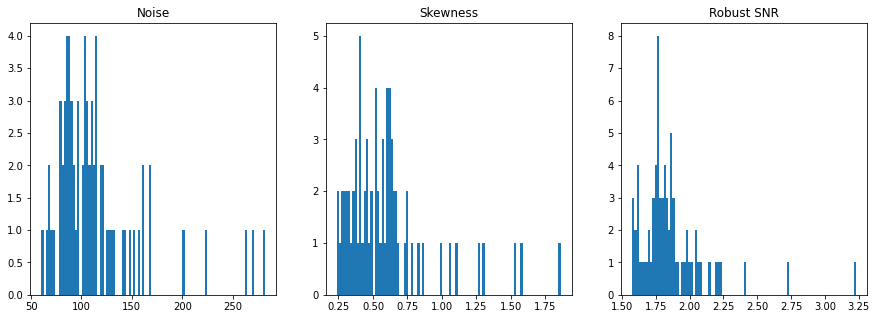

In [61]:
#plt hist of noise, skewness, robust_snr
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(noise, bins=100)
ax[0].set_title("Noise")
ax[1].hist(skewness, bins=100)
ax[1].set_title("Skewness")
ax[2].hist(robust_snr, bins=100)
ax[2].set_title("Robust SNR")
plt.show()


In [63]:
# save csv with only columns, noise, snr, skewness
save_df = dff_traces[["noise", "robust_snr", "skewness"]]
save_df.to_csv("dff_metrics.csv")

,noise,robust_snr,skewness
cell_specimen_id,,,
10,162.071484,1.757912,0.322384
11,112.761395,2.049154,0.755166
12,104.438841,1.860687,0.597191
13,85.762526,1.861929,0.523705
14,112.513291,1.741520,0.689286
...,...,...,...
75,161.28411,2.224970,0.74721
78,262.590612,1.613807,0.351564
79,223.650668,1.575522,0.342916


In [40]:
# load dff, ['baseline', 'data', 'noise', 'roi_names', 'skewness']
fp = dataset.file_paths["dff_h5"]

import h5py
with h5py.File(fp, 'r') as f:
    print(f["skewness"][:].shape)

(81,)


<xarray.DataArray 'RMSE' ()>
array(0.00506034)
Coordinates:
    cell_roi_id  int64 2

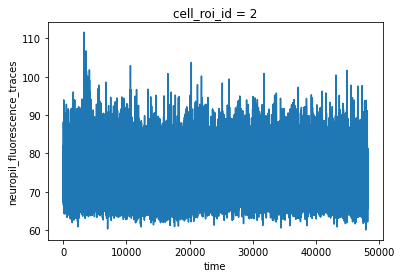

In [98]:
import xarray as xr
dataset = OphysDataset("/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1098444819")
x = dataset.neuropil_traces_xr

# get cell_roi_id 0 from x 
cell_roi_id = 1
x.sel(cell_roi_id=cell_roi_id).neuropil_fluorescence_traces.plot.line()
x.sel(cell_roi_id=cell_roi_id).RMSE


In [48]:
dataset = OphysDataset("/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1098444819")
dataset.cell_specimen_table.head()

,x,y,width,height,mask_matrix,valid_roi,mask_image_plane,exclusion_labels,cell_roi_id,max_correction_up,max_correction_down,max_correction_left,max_correction_right
cell_specimen_id,,,,,,,,,,,,,
0,44,0,6,6,"[[False, True, True, True, False, False], [Tru...",False,0,[small_size],0,0,0,0,0
1,79,12,14,17,"[[False, False, False, False, False, False, Tr...",True,0,[],1,0,0,0,0
2,206,49,20,11,"[[False, False, False, False, False, False, Fa...",True,0,[],2,0,0,0,0
3,344,58,12,11,"[[False, True, True, True, True, False, False,...",True,0,[],3,0,0,0,0
4,53,66,15,13,"[[False, False, False, False, False, False, Fa...",True,0,[],4,0,0,0,0


In [4]:
from data_objects.ophys.behavior_dataset import BehaviorDataset
dataset = OphysDataset("/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1098444819")
dataset.ophys_timestamps

NameError: name 'OphysDataset' is not defined

# OphysPlaneDataset

In [21]:
from data_objects.ophys.ophys_plane_dataset import OphysPlaneDataset
from pathlib import Path

In [19]:
# local input

from data_objects.ophys.ophys_plane_dataset import OphysPlaneDataset
processed_path = "/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1299958728/processed/"
expt_folder_path = "/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1299958728/processed/1299958728"
dataset = OphysPlaneDataset(expt_folder_path=expt_folder_path)

In [27]:
# code ocean input
# careful glob doesnt likes tilde ~
processed_path = "/root/capsule/data/multiplane-ophys_677594_2023-08-04_09-44-08_processed_2024-02-08_23-26-44"
expt_folder_path = processed_path + "/1287841795"
dataset = OphysPlaneDataset(expt_folder_path=expt_folder_path, verbose=True)


_platform.json: 1287841795/1287701514_platform.json
processing.json: 1287841795/processing.json
_params.json: events/1287841795_params.json
_registered_metrics.json: movie_qc/1287841795_registered_metrics.json
_output.json: segmentation/segmentation_output.json
_average_projection.png: motion_correction/1287841795_average_projection.png
_max_projection.png: not found
_motion_transform.csv: motion_correction/1287841795_motion_transform.csv
segmentation_output.json: segmentation/segmentation_output.json
roi_traces.h5: trace_extraction/roi_traces.h5
neuropil_correction.h5: neuropil_correction/neuropil_correction.h5
neuropil_masks.json: trace_extraction/neuropil_masks.json
neuropil_trace_output.json: neuropil_correction/neuropil_trace_output.json
demixing_output.h5: demixing/demixing_output.h5
demixing_output.json: demixing/demixing_output.json
dff.h5: dff/dff.h5
extract_traces.json: trace_extraction/extract_traces.json
events_oasis.h5: events/1287841795_events_oasis.h5


In [28]:
dataset.dff_traces

,dff,baseline,noise,skewness
cell_specimen_id,,,,
0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN
1,"[0.3501062935922123, 0.477602021911333, 0.4312...","[505.6397040812572, 505.6397040812572, 505.639...",55.879718,1.047109
10,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN
11,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN
12,"[0.18570515943607185, 0.1590643114591885, 0.26...","[806.269570249312, 806.6308185003484, 806.4501...",42.348114,0.844889
...,...,...,...,...
85,"[0.10481134856622669, 0.030425329330776477, 0....","[408.9423018190653, 408.8236278429837, 408.823...",44.430887,0.480789
86,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN
87,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN


In [31]:
dff_folder

PosixPath('~/capsule/data/multiplane-ophys_677594_2023-08-04_09-44-08_processed_2024-02-08_23-26-44/1287841795/dff')

In [32]:
!ls ~/capsule/data/multiplane-ophys_677594_2023-08-04_09-44-08_processed_2024-02-08_23-26-44/1287841795/dff

dff.h5


# Behavior

In [23]:
from data_objects.behavior.behavior_dataset import BehaviorDataset
processed_path = "/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1299958728/processed/1299958728" # give experiment
raw_path = "/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1299958728/raw"
bd = BehaviorDataset(raw_path)

In [15]:
#dataset = OphysDataset("/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1098444819")


bd.running_speed

,timestamps,speed
0,26.11250,0.140996
1,26.12920,3.092842
2,26.14540,5.968486
3,26.16202,8.641166
4,26.17937,10.995492
...,...,...
224515,3771.27779,42.359368
224516,3771.29449,42.081077
224517,3771.31114,41.780884
224518,3771.32787,41.460801


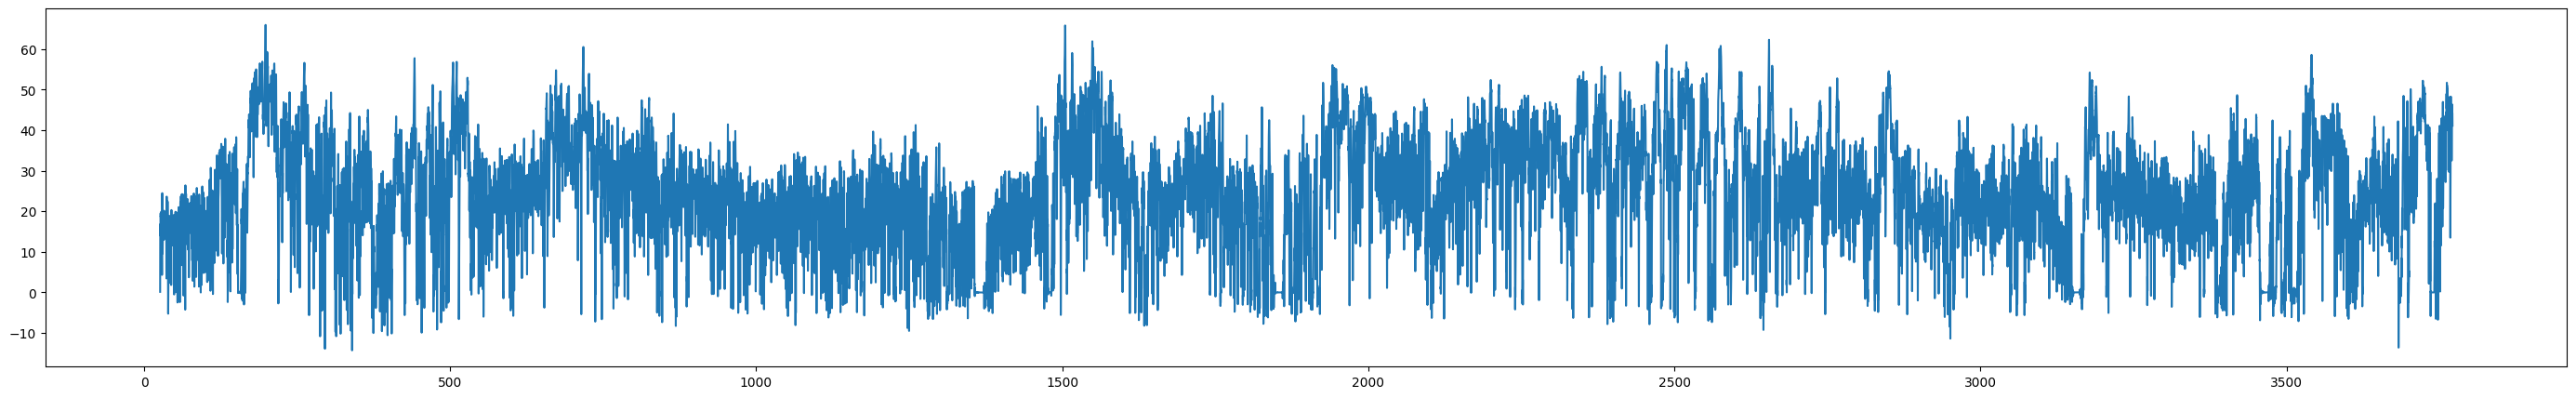

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(35, 5))
plt.plot(bd.running_speed.timestamps, bd.running_speed.speed)

In [21]:
bd.stimulus_presentations

,SF,TF,contrast,direction,duration,end_frame,index,start_frame,start_time,stimulus_name,stop_time
stimulus_presentations_id,,,,,,,,,,,
0,0.04,1.0,0.05,0.0,1.98129,1319.0,0,1200.0,46.13274,drifting_gratings_contrast,48.11403
1,0.04,1.0,0.20,315.0,1.98463,1499.0,1,1380.0,49.13191,drifting_gratings_contrast,51.11654
2,0.04,1.0,0.20,270.0,1.98465,1679.0,2,1560.0,52.13444,drifting_gratings_contrast,54.11909
3,0.04,1.0,0.20,135.0,1.98468,1859.0,3,1740.0,55.13697,drifting_gratings_contrast,57.12165
4,0.04,1.0,0.05,90.0,1.98474,2039.0,4,1920.0,58.13950,drifting_gratings_contrast,60.12424
...,...,...,...,...,...,...,...,...,...,...,...
1115,0.04,1.0,0.80,0.0,1.98461,223619.0,1115,223500.0,3754.34730,drifting_gratings_TF,3756.33191
1116,0.04,2.0,0.80,270.0,1.98461,223799.0,1116,223680.0,3757.34984,drifting_gratings_TF,3759.33445
1117,0.04,2.0,0.80,180.0,1.98479,223979.0,1117,223860.0,3760.35237,drifting_gratings_TF,3762.33716


# PKL file reading/debug

In [ ]:
# not downloaded: 20230929_692478_ophys2_175_275, 1300393608, Slc32a1-IRES-Cre;Oi1, LearningmFISHDevelopment
# main experiemnt: 20230927_692478_stage_1_175_275_, 1299958728, Slc32a1-IRES-Cre;Oi1, LearningmFISHDevelopment
    # + 1300116380 = VISp 175
    # + 1300116382 = VISp 275

In [9]:
from data_objects.behavior.grab_behavior import GrabBehavior
gbo = GrabBehavior(raw_path)
pkl_file = pd.read_pickle(gbo.file_paths["stimulus_pkl"])

In [8]:
from pathlib import Path
# get all csv in path 
fp = Path(gbo.file_paths["stimulus_pkl"])

# get all csv in path
fps = list(fp.parent.glob("*.pkl"))
fp

PosixPath('/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1299958728/raw/pophys/1299958728.pkl')

In [ ]:
pkl_file['stimuli'

In [6]:
pkl_file["items"]["foraging"]["encoders"]

[{'counter_index': 0,
  'distance': array([91.706635  ,  0.2158311 ,  0.2158311 , ...,  0.6007299 ,
          0.59353554,  0.58274394], dtype=float32),
  'mdr0_register_setting': '3',
  'base_time': 0,
  'unpickleable': [],
  'timestamp': array([   0.      ,   10.268576,   10.285456, ..., 3755.4646  ,
         3755.4814  , 3755.498   ], dtype=float32),
  'arduino_version': '0.1.6+gb8626a0.b82975',
  'treadmill': False,
  'vin': array([5., 5., 5., ..., 5., 5., 5.]),
  'vsig': [0.560302734375,
   0.596923828125,
   0.633544921875,
   0.6695556640625,
   0.7049560546875,
   0.7403564453125,
   0.7763671875,
   0.8123779296875,
   0.849609375,
   0.885009765625,
   0.921630859375,
   0.958251953125,
   1.0333251953125,
   1.0333251953125,
   1.0699462890625,
   1.143798828125,
   1.143798828125,
   1.1798095703125,
   1.2493896484375,
   1.2835693359375,
   1.2835693359375,
   1.35009765625,
   1.3818359375,
   1.414794921875,
   1.44775390625,
   1.4801025390625,
   1.5130615234375,
   1.

## Sync File Debug

In [35]:
from data_objects.sync.sync_dataset import SyncDataset
sync = SyncDataset(bd.file_paths['sync_file'])



In [59]:
sync.line_labels

['vsync_2p',
 '',
 'vsync_stim',
 '',
 'stim_photodiode',
 'stim_running',
 '',
 '',
 'beh_frame_received',
 'eye_frame_received',
 'face_frame_received',
 '',
 '',
 '',
 '',
 '',
 '',
 'stim_running_opto',
 'stim_trial_opto',
 '',
 '',
 'beh_cam_frame_readout',
 'face_cam_frame_readout',
 '',
 '',
 'eye_cam_frame_readout',
 '',
 'beh_cam_exposing',
 'face_cam_exposing',
 'eye_cam_exposing',
 '',
 'lick_sensor']

In [53]:
sync.get_line('vsync_2p')

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [54]:
sync.line_stats(line='lick_sensor')

In [60]:
sync.stats()

[{'line': 0,
  'bit': 0,
  'total_data_points': 3448517,
  'total_events': 285718,
  'total_rising': 142859,
  'total_falling': 142859,
  'avg_period': 0.026293564263564263,
  'min_period': 0.02628,
  'max_period': 0.0263,
  'period_sd': 0.0,
  'avg_freq': 38.032120330895125,
  'duty_cycle': 'fix me'},
 {'line': 2,
  'bit': 2,
  'total_data_points': 3448517,
  'total_events': 449040,
  'total_rising': 224520,
  'total_falling': 224520,
  'avg_period': 0.016681135944556783,
  'min_period': 0.00452,
  'max_period': 0.03817,
  'period_sd': 0.0,
  'avg_freq': 59.947955782130634,
  'duty_cycle': 'fix me'},
 {'line': 4,
  'bit': 4,
  'total_data_points': 3448517,
  'total_events': 3764,
  'total_rising': 1882,
  'total_falling': 1882,
  'avg_period': 1.9982563936170215,
  'min_period': 0.16677,
  'max_period': 5.17105,
  'period_sd': 0.0,
  'avg_freq': 0.500436281947739,
  'duty_cycle': 'fix me'},
 {'line': 5,
  'bit': 5,
  'total_rising': 1,
  'total_falling': 1,
  'avg_freq': None,
  'duty

In [55]:
sync.plot_all()

TypeError: plot_all() missing 2 required positional arguments: 'start_time' and 'stop_time'

# BehaviorOphysDataset

In [29]:
from data_objects.behavior_ophys_dataset import BehaviorOphysDataset

NameError: name 'StimulusFileLookup' is not defined

In [101]:
processed_path = "/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1299958728/processed/"
expt_folder_path = processed_path + "/1299958728"
raw_path = "/allen/programs/mindscope/workgroups/learning/mattd/co_dev/data/1299958728/raw"
bod = BehaviorOphysDataset(raw_path, expt_folder_path)


pkl_file = bod.behavior_stimulus_file

Currently sync file stored in raw data assest, will load since raw_folder_path is provided (02/01/2024)


In [ ]:
# code ocean input
# careful glob doesnt likes tilde ~
processed_path = "/root/capsule/data/multiplane-ophys_677594_2023-08-04_09-44-08_processed_2024-02-08_23-26-44"
expt_folder_path = processed_path + "/1287841795"
dataset = OphysPlaneDataset(expt_folder_path=expt_folder_path, verbose=True)

In [104]:
pkl_file

In [33]:
bod.dff_traces

,dff,baseline,noise,skewness
cell_specimen_id,,,,
0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN
1,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN
10,"[0.2590196997004517, 0.18960400179453218, 0.24...","[2418.167761571288, 2418.167761571288, 2418.16...",162.071484,0.322384
11,"[0.14345842641369522, 0.26765181864374543, 0.1...","[1332.4583180076627, 1332.4583180076627, 1332....",112.761395,0.755166
12,"[0.17683583095468602, 0.10960230885661967, 0.1...","[1722.1217291917526, 1722.1217291917526, 1722....",104.438841,0.597191
...,...,...,...,...
78,"[0.22188464416922554, 0.198864316383394, 0.174...","[1348.4292018823528, 1348.816582117647, 1348.4...",262.590612,0.351564
79,"[-0.16801624232420329, -0.09458193923232106, 0...","[1142.6892315256105, 1142.6892315256105, 1142....",223.650668,0.342916
8,"[0.33118886469094383, 0.11138697404849598, 0.3...","[1377.131721038961, 1377.131721038961, 1377.13...",127.592855,1.859951
